# 1. Data 

## loading and preparing

In [1]:
import sklearn
import torch
from sklearn.datasets import make_circles
from helper_functions import plot_decision_boundary

In [2]:
import matplotlib.pyplot as plt

In [3]:
n_samples = 1000
X, y = make_circles(n_samples= n_samples, noise = 0.03, random_state= 42)

In [4]:
print(f"printing the first five samples of X :\n {X[:5]}")

printing the first five samples of X :
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]


In [5]:
torch.__version__

'2.1.1+cu121'

In [6]:
# turning our data into tensors and then into training and testing splits
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)


In [8]:
len(X_train), len(X_test), len(y_train)

(800, 200, 800)

# 2. Building our model

lets build a model to classify our data into 0, 1 labels
to do so we want to:
1. setup device egnostic code so our code will run on an accelerator (GPU) if there is one 
2. Construct a model (by subclassing `nn.Module`)
3. Define a Loss function and Optimizer 
4. Create training and testing loop 


In [9]:
# Import PyTorch and nn 
import torch 
from torch import nn

#Make device egnostic code 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Now we've set our device agnostic code, let's create a model that:
 1. Subclasses `nn.Module` (almost all models in PyTorch subclasses `nn.Module`)
 2. Create 2 `nn.Linear()` "layers that are capable of handling the sapes of our data"
 3. Define a forward method that outlines the forward path (or forward computation) of the model
 4. Instantiate an instance of our model class and send it to the target device?

In [10]:
# 1.Construct a model that subclasses nn.Module
class CircleModelv1(nn.Module):
    def __init__(self):
        super().__init__()
    # 2. Create 2 nn.linear that handles our input features 
        self.layer_1 = nn.Linear(in_features = 2, out_features = 8)
        self.layer_2 = nn.Linear(in_features= 8, out_features = 1)
    # 3.Defining a forward method
    def forward(self, x : torch.tensor) -> torch.tensor:
        return(self.layer_2(self.layer_1(x)))

In [11]:
# 4. Instantiate an instance from our model
model_0 = CircleModelv1().to(device)

In [12]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=32),
    nn.ReLU(),
    nn.Linear(in_features=32, out_features=10),
    nn.ReLU(),
    nn.Linear(in_features= 10, out_features= 1)
).to(device)


### setup loss function and optimzer

which loss or optimzer should we use  ?

again this is problem specific 

For example for regression you might want to use MAE or MSE

For classification problems you might want to use binarycross entropy or categorical cross entropy for multiclass classification 

as a reminder the loss function measures how your model is wrong in it's predictions 




"" in contex of deep learning the logits layer mean the layer that feeds in to softmax layer(or other such normalization). The output of the softmax are the probabilities for a classification task and its input is logits layer "" -------------------> this is the layer before the softmax layer i.e. before output layer 

In [13]:
loss_fnc = nn.BCEWithLogitsLoss()


optimzer = torch.optim.Adam(params= model_0.parameters(), lr = 0.01)

In [14]:
def accuracy(y_true, y_preds):
    correct = (torch.eq(y_true, y_preds)).sum().item()
    acc = (correct/len(y_true)) * 100 
    return acc

## 3. Training loop

1. Call model.train
2. Calculate the forward path 
3. Claculate the loos 
4. optimzer dot zero graddd
5. Loss backward
6. Optimzer step step steppp!!!


### 3.1 Going from raw logits -> prediction probabilities -> prediction labels 

our model outputs are going to be raw **logits**.

We can convert this logits into prediciton probabilites by passing them into some kind of activation function(e.g sigmoid or binary cross entropy or\
softmax for multilabel classification)
then we can now convert our model's prediction probabilites to prediction labels by either rounding them or taking the `argmax()`

In [15]:
# use a sigmoid activation function on our data to output 0, 1 
y_preds = torch.round(torch.sigmoid(model_0(X_test.to(device))))

correct = (torch.eq(y_test.to(device),y_preds.squeeze())).sum().item()

acc_with_out_training = (correct/ len(y_preds)) * 100 

acc_with_out_training



50.0

## Building traing and testing loops

In [16]:
torch.cuda.manual_seed(42)

In [17]:
X_train, X_test , y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

In [18]:
epochs = 70

for epoch in range(epochs):

    #call model train
    model_0.train()

    #do the forward path
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    #calculate the loss
    loss = loss_fnc(y_logits,
                    y_train) # BCEwithlogitsloss expects raw logits as input   but if you choose BCEloss you need to input the prediction probabilities y_preds
    
    acc =  accuracy(y_train, y_preds)

    #optimzer dot zero grad
    optimzer.zero_grad()

    #loss backward
    loss.backward()

    #optimzer step 
    optimzer.step()

    # model testing "evaluation"
    model_0.eval()

    with torch.inference_mode():

        #calculate the forward path
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        #calculate the test loss
        test_loss = loss_fnc(y_test, test_logits)
        test_acc = accuracy(y_test, test_preds)

    #printing what's happening 
    if epoch % 10 == 0:
        print(f"Epoch : {epoch} | Loss : {loss:.5f} | Accuracay : {acc:.2f}% Test Loss : {test_loss:.5f} | Test Accuracay : {acc:.2f} %")
    # if epoch % 20 == 0:
    #         plt.figure(figsize=(3,3))
    #         plt.subplot(1,2,1)
    #         plt.title("Train")
    #         plot_decision_boundary(model_0, X_train.cpu(), y_train.cpu())
    #         plt.subplot(1, 2, 2)
    #         plt.title("Test")
    #         plot_decision_boundary(model_0, X_test.cpu(), y_test.cpu())


Epoch : 0 | Loss : 0.69568 | Accuracay : 50.00% Test Loss : 0.98999 | Test Accuracay : 50.00 %
Epoch : 10 | Loss : 0.68217 | Accuracay : 55.38% Test Loss : 1.02014 | Test Accuracay : 55.38 %
Epoch : 20 | Loss : 0.65829 | Accuracay : 68.75% Test Loss : 1.02875 | Test Accuracay : 68.75 %
Epoch : 30 | Loss : 0.61307 | Accuracay : 88.50% Test Loss : 0.97891 | Test Accuracay : 88.50 %
Epoch : 40 | Loss : 0.53601 | Accuracay : 94.50% Test Loss : 0.92140 | Test Accuracay : 94.50 %
Epoch : 50 | Loss : 0.42274 | Accuracay : 95.25% Test Loss : 0.84743 | Test Accuracay : 95.25 %
Epoch : 60 | Loss : 0.32564 | Accuracay : 98.75% Test Loss : 0.74389 | Test Accuracay : 98.75 %


In [19]:
y_logits.shape, X_train.shape

(torch.Size([800]), torch.Size([800, 2]))

In [20]:
torch.sigmoid(y_logits[0:4])

tensor([0.6859, 0.1721, 0.0423, 0.0636], device='cuda:0',
       grad_fn=<SigmoidBackward0>)

# we could not achieve any high accuracy cause of we are not using any non lineaity so we aren't going to learn any complex patterns

In [21]:
import requests 
import pathlib

In [22]:
# Download helper functions from pytorch deeplearning

if pathlib.Path("helper_functions.py").exists():
    print("helper_function.py already exists")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)


helper_function.py already exists


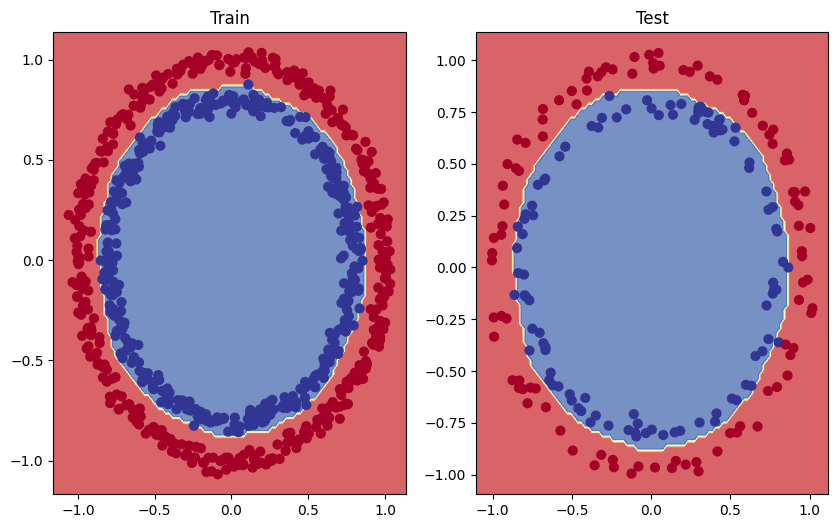

In [23]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## Putting it all together with a multi-class classification problem 

* Binary classification = one thing or another(cat versus dog, spam versus not spam)
* Multi-class classification = more than one thing or another (cat vs dog vs chicken)

#### Perepare the data 
1. turning data into tensors
2. spiltting the data into train and test using `train_test_split()`
3. making device agnostic code
4. sending our data into what ever device is available


In [99]:
# creating a toy multi-class dataset

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

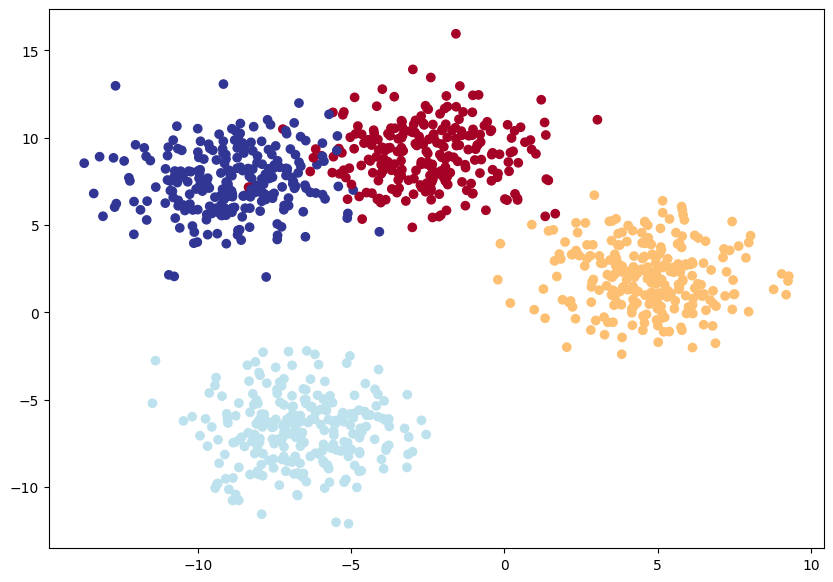

In [100]:
# 1.setting the perameters of the dataset function
NUMBER_OF_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED  = 42

# 2.create multi-class data
X_blob, y_blob = make_blobs(1000,
                            n_features=NUM_FEATURES,
                            centers= NUMBER_OF_CLASSES,
                            cluster_std= 1.8,
                            random_state= RANDOM_SEED)

# 3.Turning data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_train, X_test, y_train, y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size = 0.2,
                                                    random_state=RANDOM_SEED)

# 4. Plot data (visualizing)
plt.figure(figsize =(10, 7))
plt.scatter(X_blob[ : , 0 ],X_blob[ : , 1 ], c = y_blob, cmap = plt.cm.RdYlBu)

In [60]:
#Turning our labels into one hot encoding format
#y_train, y_test = torch.eye(4)[y_train],  torch.eye(4)[y_test]

In [101]:
# sending the data to the device we are using 

X_train, X_test, y_train, y_test = X_train.to(device), X_test.to(device), y_train.to(device), y_test.to(device)

In [102]:
# 1.choosing our model architict
# input features are 2
model_1 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 8),
    nn.ReLU(),
    nn.Linear(in_features = 8, out_features= 32),
    nn.ReLU(),
    nn.Linear(in_features = 32, out_features = 128),
    nn.ReLU(),
    nn.Linear(in_features = 128, out_features = 32),
    nn.ReLU(),
    nn.Linear(in_features = 32, out_features = 4),
    #nn.Softmax() #output softmax layer because we are dealing with multi-class classification task
).to(device= device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=128, bias=True)
  (5): ReLU()
  (6): Linear(in_features=128, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=4, bias=True)
)

In [80]:
# # lets our model's predictons without any training
# with torch.inference_mode():
#     y_without_training = model_1(X_train[:10]).squeeze()


# # loss = nn.creo(y_train[:10], y_without_training)

In [103]:
# 2. choosing Loss_function and the optmizer_function
loss_fnc_model_1 = nn.CrossEntropyLoss() 
optimzer_model_1 = torch.optim.Adam(params = model_1.parameters(), lr = 0.01)

In [104]:
#accuracy function 
def accuracy(y_true, y_preds):
    correct = (torch.eq(y_true, y_preds)).sum().item()
    acc = (correct/len(y_true)) * 100 
    return acc

In [105]:
# making our_train and testing_loops
epochs = 200
training_loss_count = []
epoch_count = []
testing_loss_count = []
training_accuracy_count = []
testing_accuracy_count = []
# training loop 
for epoch in range(epochs):
    #calling model.train() to train our model into train mode
    model_1.train()
    # making the forward path for the model
    y_logits = model_1(X_train).squeeze()
    #calculate the loss
    train_loss = loss_fnc_model_1(y_logits, y_train)
    y_preds = torch.softmax(y_logits, dim = 1).argmax(dim = 1)
    train_accuracy = accuracy(y_train, y_preds)
    #optimzer zero grad to initialized with zero after each iteration
    optimzer_model_1.zero_grad()
    # Backprobagation
    train_loss.backward()
    # optimzer step
    optimzer_model_1.step()
    # model evaluation calling model.eval()
    model_1.eval()
    test_logits = model_1(X_test)
    test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)
    test_loss = loss_fnc_model_1(test_logits, y_test)
    test_accuracy = accuracy(y_test, test_preds)
    #printing what's happening 
    if epoch % 10 == 0:
        epoch_count.append(epoch)
        training_loss_count.append(train_loss)
        testing_loss_count.append(test_loss)
        training_accuracy_count.append(train_accuracy)
        testing_accuracy_count.append(test_accuracy)
        print(f"Epoch : {epoch} | Training Loss : {loss:.5f} | Training Accuracay : {train_accuracy:.2f}% Test Loss : {test_loss:.5f} | Test Accuracay : {test_accuracy:.2f} %")
    

Epoch : 0 | Training Loss : 0.24955 | Training Accuracay : 24.38% Test Loss : 1.18847 | Test Accuracay : 74.00 %
Epoch : 10 | Training Loss : 0.24955 | Training Accuracay : 97.75% Test Loss : 0.08816 | Test Accuracay : 98.00 %
Epoch : 20 | Training Loss : 0.24955 | Training Accuracay : 98.38% Test Loss : 0.02519 | Test Accuracay : 99.00 %
Epoch : 30 | Training Loss : 0.24955 | Training Accuracay : 98.38% Test Loss : 0.02094 | Test Accuracay : 98.50 %
Epoch : 40 | Training Loss : 0.24955 | Training Accuracay : 98.38% Test Loss : 0.01987 | Test Accuracay : 99.00 %
Epoch : 50 | Training Loss : 0.24955 | Training Accuracay : 97.75% Test Loss : 0.04749 | Test Accuracay : 98.00 %
Epoch : 60 | Training Loss : 0.24955 | Training Accuracay : 98.12% Test Loss : 0.02456 | Test Accuracay : 99.00 %
Epoch : 70 | Training Loss : 0.24955 | Training Accuracay : 98.38% Test Loss : 0.02688 | Test Accuracay : 99.00 %
Epoch : 80 | Training Loss : 0.24955 | Training Accuracay : 98.50% Test Loss : 0.02949 | 

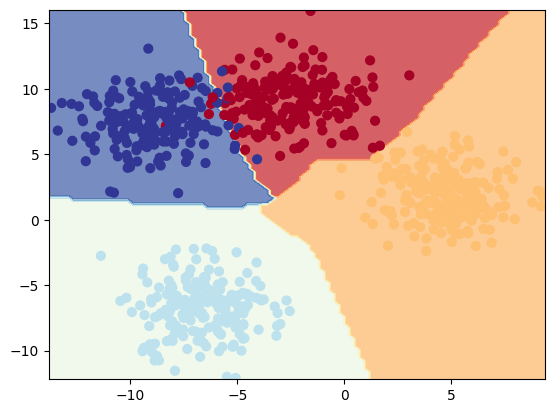

In [106]:
plot_decision_boundary(model_1,X_train, y_train)

In [107]:
with torch.inference_mode():
    prediction = model_1(X_test[:5].cpu())

torch.argmax(torch.softmax(prediction, dim = 1),dim =1)

tensor([1, 3, 2, 1, 0])

In [108]:
y_test[:5]

tensor([1, 3, 2, 1, 0], device='cuda:0')

### plot of loss and accuracy curves

In [117]:
# converting the lists into numpy arries so matplotlib can deal with
epoch_count = torch.tensor(epoch_count).cpu().numpy()
training_loss_count = torch.tensor(training_loss_count).cpu().numpy()
testing_loss_count = torch.tensor(testing_loss_count).cpu().numpy()
training_accuracy_count = torch.tensor(training_accuracy_count).cpu().numpy()
testing_accuracy_count = torch.tensor(testing_accuracy_count).cpu().numpy()

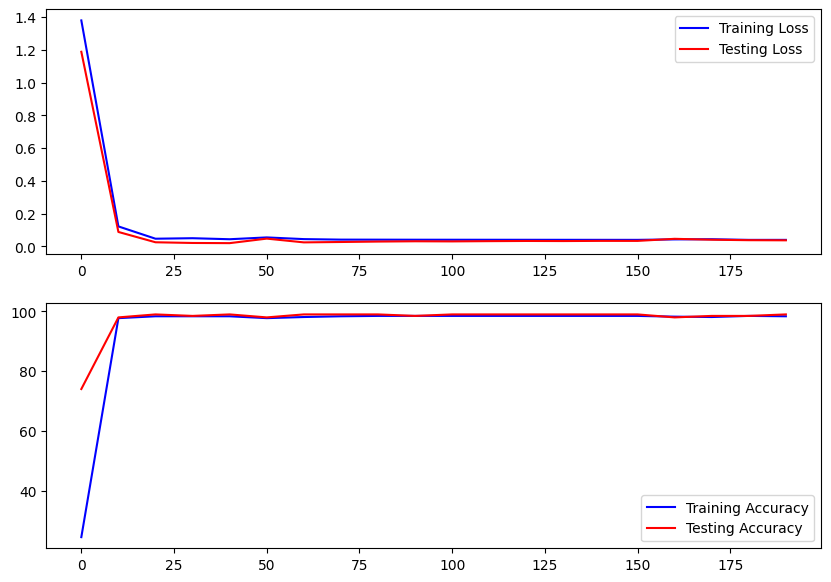

In [118]:
plt.figure(figsize = (10,7))
plt.subplot(2, 1, 1)
plt.plot(epoch_count, training_loss_count, c = 'blue', label = "Training Loss")
plt.plot(epoch_count, testing_loss_count, c = 'r', label = "Testing Loss")
plt.legend()
plt.subplot(2,1,2)
plt.plot(epoch_count, training_accuracy_count, c = 'b', label = "Training Accuracy")
plt.plot(epoch_count, testing_accuracy_count, c = 'r', label = "Testing Accuracy")
plt.legend()
plt.show()